In [1]:
## plot boilerplate
%matplotlib inline
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)
mpl.rcParams['figure.figsize'] = (12.0, 8.0)

## Prepare Test Data

Below we test the pipeline using the newsgroup data set.

First we create a target data set by writing newsgroup data labled `comp.graphics` from the training set to one line in a jsonl file, `test/target.jsonl`.  This data set represents combining multiple employee resumes that represent ideal hires for a particular job requisite.

Next we write all categories from the newsgroup test data set line by line to a jsonl file, `test/candidate.jsonl`.  Each line in this file represents a candidate's resume for comparison with the target file.

If the pipeline works then we would expect that candidate items labeled `comp.graphics` would score higher in general than items with other labels.

---

In [2]:
## prepare the data for testing

import json
from sklearn.datasets import fetch_20newsgroups

categories = ['alt.atheism', 'soc.religion.christian', 'comp.graphics', 'sci.med']
twenty_train = fetch_20newsgroups(subset='train',
                                  categories=categories, shuffle=True, random_state=42)
twenty_test = fetch_20newsgroups(subset='test',
                                 categories=categories, shuffle=True, random_state=42)

target_content = ''
for i in range(len(twenty_train.data)):
    if twenty_train.target_names[twenty_train.target[i]] == 'comp.graphics':
        target_content += twenty_train.data[i]

with open('test_data/target.jsonl', 'w') as tf:
    json.dump({'name':'target', 'content': target_content}, tf)

with open('test_data/candidate.jsonl', 'w') as cf:
    for i in range(len(twenty_test.data)):
        json.dump({'name': twenty_test.target_names[twenty_test.target[i]],
                   'content': twenty_test.data[i]
                  }, cf)
        cf.write('\n')

## Calculate Similarity 

---

In [4]:
from pdftojsonl import process_pdfs
from txtprocess import KeySelect, StripTransform, CosineSim
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

pipe = Pipeline([
    ('bykey', KeySelect()),
    ('clean', StripTransform()),
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('cosine', CosineSim())
])

with open('test_data/target.jsonl', 'r') as tf, open('test_data/candidate.jsonl', 'r') as cf:
    d = 1 - pipe.fit(
        (json.loads(line) for line in tf), None
    ).predict((json.loads(line) for line in cf))

## Plot Results

Above we defined `d` which is a vector of similarity scores for each document.  It is in the same order as the original candidate json list. We can use this order to combine the scores with the labels and generate plots or tables.

---

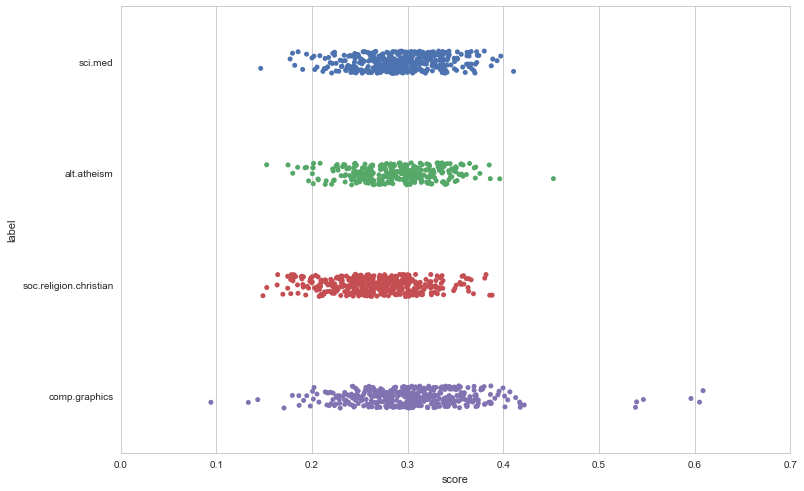

In [6]:
with open('test_data/candidate.jsonl', 'r') as cf:
    result = [r for r in zip([json.loads(line)['name'] for line in cf], d[0,:])]
df = pd.DataFrame(result, columns=['label', 'score'])
sns.stripplot(x="score", y="label", data=df, jitter=True);

Ok.. so not great. In the plot above we can see that we get a slight lift from the cosine similarity measure, but the categories become indistinguishable below `0.4`.